In [1]:
import sys
sys.path.append('/home/lo276838/Modèles/mri-dl-recon/src/mri_dlrecon')

In [2]:
from fastmri.data import transforms as T
import torch
import os
import numpy as np
from matplotlib import pyplot as plt
from torch.autograd import Variable

from utils_torch import virtual_coil_reconstruction, load_and_transform, create_zero_filled_reconstruction
from fastmri.data.subsample import create_mask_for_mask_type
from fastmri.models.unet import Unet


In [8]:
plt.rcParams['figure.figsize'] = (7, 7)
plt.rcParams['image.cmap'] = 'gray'

In [12]:
file_path = "/volatile/FastMRI/brain_multicoil_train/multicoil_train"
mask_type = "magic_fraction"
center_fractions = [0.08, 0.04]
accelerations = [4, 8]

mask = create_mask_for_mask_type(mask_type, center_fractions, accelerations)
paires = []

excluded_file_names = ["file_brain_AXT1POST_201_6002780.h5", "dataset"] 

all_files = os.listdir(file_path)

file_pathX = [f for f in all_files if f not in excluded_file_names]

for file in file_pathX:
    kspace_m = load_and_transform(os.path.join(file_path, file))

    target = virtual_coil_reconstruction(torch.fft.fftshift(torch.fft.ifft2(kspace_m)))
    target = target.abs().unsqueeze(1)

    kspace = virtual_coil_reconstruction(kspace_m)
    zero_filled = create_zero_filled_reconstruction(mask, kspace)

    # paires.append((kspace, target))
    paires.append((zero_filled, target))

In [5]:
# for tuple in paires :
#     plt.subplot(1,2,1)
#     plt.imshow(np.abs(torch.fft.ifftshift(torch.fft.ifft2(tuple[0]))[0, :,: ].numpy()))
#     plt.title("Input")

#     plt.subplot(1,2,2)
#     plt.imshow(np.abs(tuple[1][0, 0, :,: ].numpy()))
#     plt.title("Target")

#     plt.tight_layout()
#     plt.show()

In [22]:
chans = 32
num_pool_layers = 4

model = Unet(in_chans=1, out_chans=1, chans=chans, num_pool_layers=num_pool_layers)
criterion = torch.nn.L1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

num_epochs = 3 #zac = 200
for epoch in range(num_epochs):
    for batch_images, batch_labels in paires:
        inputs = Variable(batch_images)
        targets = Variable(batch_labels)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        # print(loss)

        loss.backward()
        optimizer.step()

    # print(f'Epoch [{epoch+1}/{num_epochs}]')

# Sauvegarder le modèle
torch.save(model.state_dict(), 'fastmri_unet_model.pth')


Test

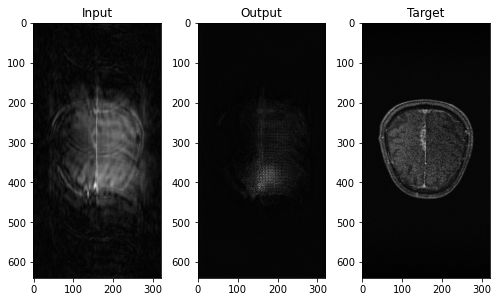

In [27]:
model = Unet(in_chans=1, out_chans=1, chans=chans, num_pool_layers=num_pool_layers)
model.load_state_dict(torch.load('fastmri_unet_model.pth'))

file_path = "/volatile/FastMRI/brain_multicoil_train/multicoil_train/file_brain_AXT1POST_201_6002780.h5"
kspace_m = load_and_transform(file_path)
kspace = virtual_coil_reconstruction(kspace_m)
masked_image = create_zero_filled_reconstruction(mask,kspace)

test_image = masked_image

model.eval()
with torch.no_grad():
    predicted_images = model(test_image)
model.train()

plt.subplot(1,3,1)
plt.imshow(np.abs(test_image[0, 0, :,: ].numpy()))
plt.title("Input")

plt.subplot(1,3,2)
plt.imshow(np.abs(predicted_images[0, 0, :,: ].numpy()))
plt.title("Output")

plt.subplot(1,3,3)
plt.imshow(np.abs(virtual_coil_reconstruction(torch.fft.fftshift(torch.fft.ifft2(kspace_m)))[0,:,:].numpy()))
plt.title("Target")

plt.tight_layout()
plt.show()